In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions import Categorical
import numpy as np
from math import exp

In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


In [3]:
with open('input.txt', 'r') as f:
  data = f.read()

In [4]:
chars = sorted(list(set(data)))
data_size, vocab_size = len(data), len(chars)
print('Total number of characters:', data_size)
print('Number of unique characters:', vocab_size)

Total number of characters: 1115393
Number of unique characters: 65


In [5]:
# char to int and int to char maps
char_to_int = {ch:i for i,ch in enumerate(chars)}
int_to_char = {i:ch for i,ch in enumerate(chars)}

In [6]:
# convert data from chars to ints
data = list(data)
for i, ch, in enumerate(data):
  data[i] = char_to_int[ch]

data = torch.tensor(data).to(device)
data = torch.unsqueeze(data, dim=1)    

In [7]:
int_to_char[data[0].item()]

'F'

In [8]:
class CharRNN(nn.Module):
    def __init__(self, input_size, output_size, hidden_size, num_layers):
        super(CharRNN, self).__init__()
        self.embedding = nn.Embedding(input_size, input_size)
        self.rnn = nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers)
        self.decoder = nn.Linear(hidden_size, output_size)
    
    def forward(self, input_seq, hidden_state):
        embedding = self.embedding(input_seq)
        output, hidden_state = self.rnn(embedding, hidden_state)
        output = self.decoder(output)
        return output, (hidden_state[0].detach(), hidden_state[1].detach())

In [11]:
# model
hidden_size = 256
num_layers = 3
learning_rate = 0.001
rnn = CharRNN(vocab_size, vocab_size, hidden_size, num_layers).to(device)

In [12]:
def train(net, epochs, data, batch_size, optimizer, criterion, print_every=2000):
  print('[epoch, batch, \tloss]')
  perplexity = []
  perplexity2 = []
  for epoch in range(epochs):
    n = 0
    running_loss = 0.0
    hidden_state = None
    
    # either start from 0 every time, or start on one of the first 100 letters
    #data_ptr = 0
    data_ptr = np.random.randint(batch_size)

    while True:
      input_seq = data[data_ptr : data_ptr + batch_size]
      target_seq = data[data_ptr + 1: data_ptr + batch_size + 1]

      optimizer.zero_grad()

      output, hidden_state = rnn(input_seq, hidden_state)
      loss = criterion(torch.squeeze(output), torch.squeeze(target_seq))      
      loss.backward()
      optimizer.step()

      running_loss += loss.item()
      
      # calculate perplexity
      # perplexity.append(torch.exp(loss.item())) ? 
      perplexity.append(torch.exp(loss))

      data_ptr += batch_size
      
      if n % print_every == (print_every-1):    
        print(f'[{epoch+1}, {n+1}, \t{running_loss/print_every}]')
        perplexity2.append(exp(running_loss/print_every))
        running_loss = 0.0
      n += 1
      if data_ptr + batch_size + 1 > data_size:
        break

  return perplexity, perplexity2
      

In [13]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(rnn.parameters(), lr=learning_rate)
epochs = 5
batch_size = 100

In [14]:
perplexity, perplexity2 = train(rnn, epochs, data, batch_size, optimizer, loss_fn, 2000)

[epoch, batch, 	loss]
[1, 2000, 	2.2106442440748215]
[1, 4000, 	1.7349377221167088]
[1, 6000, 	1.648948171108961]
[1, 8000, 	1.5655256682038308]
[1, 10000, 	1.5084424422085285]
[2, 2000, 	1.4551371993124484]
[2, 4000, 	1.398803160250187]
[2, 6000, 	1.431232016414404]
[2, 8000, 	1.3998159711658955]
[2, 10000, 	1.3713747499883175]
[3, 2000, 	1.3495148959755898]
[3, 4000, 	1.3074174446761608]
[3, 6000, 	1.3530065718889237]
[3, 8000, 	1.3323676854372024]
[3, 10000, 	1.308713010430336]
[4, 2000, 	1.2965769491195678]
[4, 4000, 	1.255521561384201]
[4, 6000, 	1.3078864493966103]
[4, 8000, 	1.2911603446304798]
[4, 10000, 	1.2722841582298279]
[5, 2000, 	1.2625220565199853]
[5, 4000, 	1.2237513718605042]
[5, 6000, 	1.2776002148091794]
[5, 8000, 	1.2635477679669858]
[5, 10000, 	1.2475040101408958]


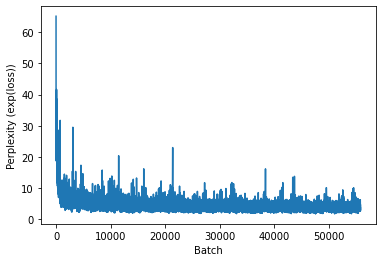

In [23]:
import matplotlib.pyplot as plt
plt.plot(torch.FloatTensor(perplexity))
plt.xlabel('Batch')
plt.ylabel('Perplexity (exp(loss))')
plt.show()

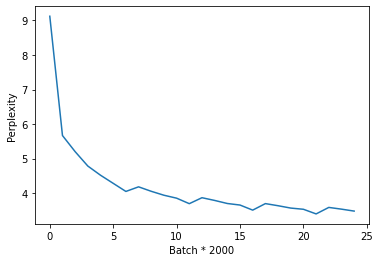

In [25]:
# As a comparison, we also plot perplexity2
# which is the perplexity for every 2000 batch 
plt.plot(torch.FloatTensor(perplexity2))
plt.xlabel('Batch * 2000')
plt.ylabel('Perplexity')
plt.show()

In [21]:
# Save model
torch.save(rnn.state_dict(), 'charRNN_ 5epochs_3layers_256_random.pth')

In [26]:
load_model = False
if load_model:
  model = CharRNN(vocab_size, vocab_size, hidden_size, num_layers)
  model.load_state_dict(torch.load('charRNN_5epochs_3layers_random.pth'))

In [36]:
# Generate text
def generate(model, input_text, output_lenght=200):
  input = list(input_text)

  for i, ch, in enumerate(input):
    input[i] = char_to_int[ch]

  input = torch.tensor(input).to(device)
  input = torch.unsqueeze(input, dim=1) 


  # use input to build up hidden state
  hidden_state = None
  for i in range(len(input)-1):
    input_seq = input[i].unsqueeze(dim=0)
    _, hidden_state = rnn(input_seq, hidden_state)
    
    # print input character
    print(int_to_char[input[i].item()], end = '')


  # use the build-up hidden state and the last character in the given input 
  # text as first input to generate new text

  input_seq = input[-1].unsqueeze(dim=0)
  print(int_to_char[input[-1].item()], end = '')

  for _ in range(output_lenght):
    # forward pass
    output, hidden_state = rnn(input_seq, hidden_state)

    # construct categorial distribution and sample a character
    output = F.softmax(torch.squeeze(output), dim=0)
    distribution = Categorical(output)
    index = distribution.sample()

    # print the sampled character
    print(int_to_char[index.item()], end = '')
    
    # want input_seq in the format ([[x]], cuda)
    input_seq = index.unsqueeze(dim=0).unsqueeze(dim=0)


In [37]:
# Task 2
# code that create a 5-char long sequence from vocab
str = ''
for i in range(5):
  str += int_to_char[np.random.randint(vocab_size)]

print(str)

generate(rnn, str, 100)

v;WWw
v;WWwinter! What
not cottaff mockeding?

ANTONIO:
I am the rank and agraigor with,--

ANTONIO:
Let me tha

In [38]:
generate(rnn, 'The', 400)

There,
Saint Sainted and then every weakness withal or legenne,
We would vice of this grave as little; thou salt,
So, forthy kind his face, one kind my life.

GONZALO:
What, into the god of shiettess of his
sooth, stay e'er flent, the Duke of Signior
And eat of a day
Which worthwake, two sight should have done:
Too knave wides, advantage; to have a soul.

ANTONIO:
O, time, my lords of such a made in 

In [45]:
generate(rnn, 'Shall I give', 100)

Shall I give!
How then are the time, serves thy forth slave,
When I'll kern the roar.

GONZALO:
What office his 

In [43]:
generate(rnn, 'What is', 100)

What is the mat-dam more.

ANTONIO:
Here but not us, what you both to the queen;
Who never him of some dove

In [44]:
generate(rnn, 'XhNYB BHN BYFVuhsdbs', 100)

XhNYB BHN BYFVuhsdbshal:
As eat?

ANGELO:
What, of either joy!

SEBASTIAN:
No, sir, but mising of sub! guel, rates!

SEB